# Load data and packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# #------------tensoflow libraries-----------------
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

Downloaded image dataset from kaggle and saved in my google drive

In [2]:
!gdown --id 1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE -O jellyfish.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE
From (redirected): https://drive.google.com/uc?id=1alX-3H9Hs3DU1H6XPug31skAq7sGUuEE&confirm=t&uuid=0296e0a2-4ee9-4ad5-bb10-4fb010c5c992
To: /content/jellyfish.zip
100% 26.8M/26.8M [00:00<00:00, 44.2MB/s]


In [3]:
!unzip -q jellyfish.zip

In [4]:
!ls

barrel_jellyfish  compass_jellyfish  lions_mane_jellyfish     Moon_jellyfish  Train_Test_Valid
blue_jellyfish	  jellyfish.zip      mauve_stinger_jellyfish  sample_data


Checking image directories, images are saved in various folders, I will use the Train_Test_Valid folder

In [5]:
import os
current_directory = os.getcwd()
print(current_directory)

/content


In [8]:
# check if the directory exists
import os
jellyfish_dir = "/content/Train_Test_Valid"
if os.path.exists(jellyfish_dir):
  print(f"Jellyfish directory found at: {jellyfish_dir}")
else:
  print("Jellyfish directory not found. Please check the path.")

Jellyfish directory found at: /content/Train_Test_Valid


# Image preprocessing and augmentation

In [4]:
def DataCreation(train_dir, test_dir, val_dir, batch_size):
    #data transformations on train images for data augmentation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=15,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.005,
                      zoom_range=[0.95, 1.2], # try to avoid extreme distortions
                      horizontal_flip=True,
                      vertical_flip=False,
                      brightness_range=(.8,1.2),
                      fill_mode='reflect', # can be a better mode when "nearest" cause distortion
                      )
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0) # no augmentation to the test or validation datasets
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # images are stored in folder subdirectories so we use .flow_from_directory
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                      shuffle=True,
                                                      target_size = (224,224),
                                                      class_mode = 'categorical', # this performs one-hot encoding
                                                      batch_size = batch_size)
    test_generator = test_datagen.flow_from_directory(train_dir,
                                                      target_size = (224,224),
                                                      class_mode = 'categorical',
                                                      batch_size = batch_size)
    val_generator = val_datagen.flow_from_directory(test_dir,
                                                      target_size=(224, 224),
                                                      batch_size=batch_size,
                                                      class_mode='categorical')
    return train_generator, test_generator, val_generator


In [5]:
train_dir= "/content/Train_Test_Valid/Train"
test_dir= "/content/Train_Test_Valid/test"
val_dir= "/content/Train_Test_Valid/valid"
batch_size= 32

train_generator, test_generator, val_generator = DataCreation(train_dir, test_dir, val_dir, batch_size)

Found 900 images belonging to 6 classes.
Found 900 images belonging to 6 classes.
Found 40 images belonging to 6 classes.


check that the image augmentations look okay

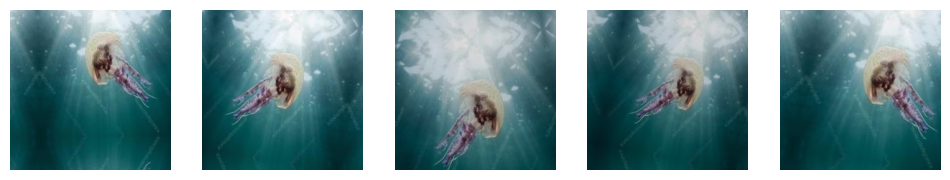

In [6]:
import matplotlib.pyplot as plt
# Plot 5 augmentations of 1st image in train generator
augmented_images = [train_generator[0][0][0] for i in range(5)]

plt.figure(figsize=(12,12))
for i in range(5):
  plt.subplot(1, 5, i+1) # Arrange plots in a single row
  plt.imshow(augmented_images[i]) # Plot the image directly if RGB
  plt.axis('off')

# Defining steps size

Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction.

The model needs a clear definition of steps per epoch, which is calculated below. This tells Keras how many batches make up ONE FULL EPOCH. One epoch will see each image, or an augmenteed version of it, once. This also means, most epochs will see a different augmented version of the respective image - train_generator with datagen_train is called new for each epoch (it could probably happen that the same arguments are chosen and there are repetitons of augmented images)

In [7]:
steps_train = round(train_generator.n / batch_size)
steps_val = round(val_generator.n / batch_size)
steps_test = round(test_generator.n / batch_size)

steps_train, steps_val, steps_test

(28, 1, 28)

# CNN from scratch

In [8]:
from tensorflow.keras import layers, models
import keras

In [14]:
# get number of classes to specify number of neurons in the final dense layer of model
cls_train = train_generator.classes
cls_test = test_generator.classes


num_classes= len(np.unique(cls_train))
num_classes

6

In [24]:
# Build a simple CNN from scratch
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 346112)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      88,604,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,699,718 (338.36 MB)

 Trainable params: 88,699,718 (338.36 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Define the EarlyStopping callback
epochs = 30

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
early_stopping_cb

In [25]:
# Compile the model with an adam optimizer.
# Fit it to the training data (use the training and validation generators defined above)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(), # because of one-hot encoding
              # otherwise with multiclass prediction we would use SparseCategoricalCrossentropy()
              metrics=['categorical_accuracy']) # and sparse_categorical_accuracy

history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_train,
                    validation_data=val_generator,
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 599ms/step - categorical_accuracy: 0.2229 - loss: 4.3456 - val_categorical_accuracy: 0.3250 - val_loss: 1.5171
Epoch 2/30
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - categorical_accuracy: 0.3438 - loss: 1.4902

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.3438 - loss: 1.4902 - val_categorical_accuracy: 0.3500 - val_loss: 1.4219
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - categorical_accuracy: 0.3560 - loss: 1.5354 - val_categorical_accuracy: 0.5750 - val_loss: 1.2050
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.3750 - loss: 1.4944 - val_categorical_accuracy: 0.5000 - val_loss: 1.2100
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - categorical_accuracy: 0.3812 - loss: 1.4079 - val_categorical_accuracy: 0.4500 - val_loss: 1.3372
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.5312 - loss: 1.2859 - val_categorical_accuracy: 0.4500 - val_loss: 1.3018
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 430ms/step - categorical_accuracy: 0.4831 - loss: 1.2414 - val_categorical_accuracy: 0.5000 - val_loss: 1.3587
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.6562 - loss: 1.1280 - va

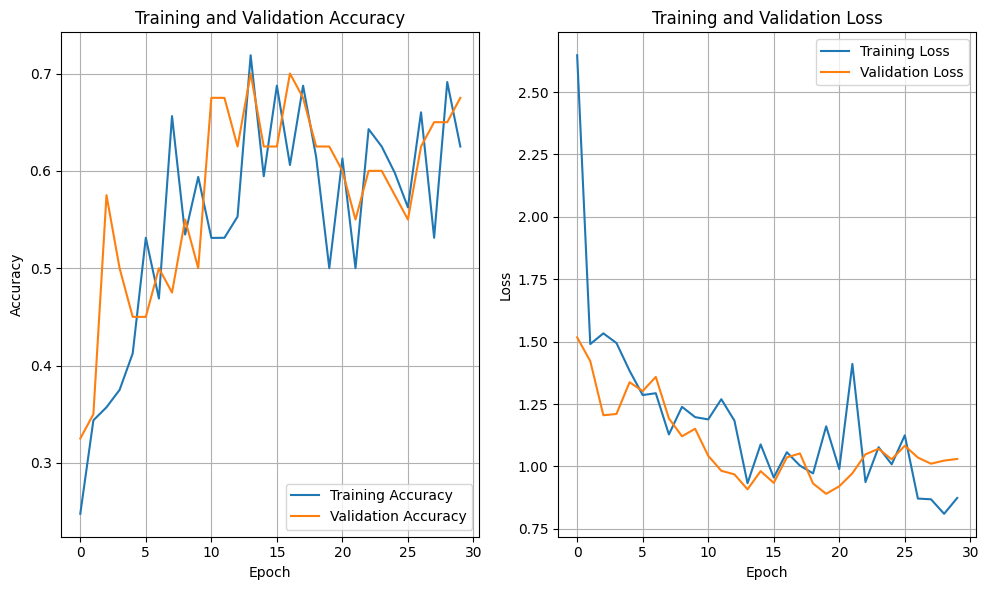

In [26]:
# Plot the training history.

def plot_history(history):
  #TODO
  pass

import seaborn as sns
import matplotlib.pyplot as plt
#lst_metrics = ['categorical_accuracy']

# Extract the metrics from the history object
metrics_df = pd.DataFrame(history.history)

# Plot the training history for 'categorical_accuracy'
fig, axes= plt.subplots(1, 2, figsize=(10, 6))

# Plot Accuracy
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy')
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss')
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [27]:
# Evaluate the model performance on the test data (use the test_generator defined above)

result = model.evaluate(test_generator, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - categorical_accuracy: 0.6997 - loss: 0.7801
Test-set classification accuracy: 69.64%


baseline is *69.64*% accuracy

# Transfer learning with Resnet50

## Run vanilla Resnet50 (with new top)

In [9]:
model_name = 'resnet50_v01'

# load a new instance of the model.
model = tf.keras.applications.resnet50.ResNet50(input_shape=(224,224,3),
                                                include_top=False, # Do not include the ImageNet classifier at the top.
                                                weights='imagenet', # Load weights pre-trained on ImageNet.
                                                )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [11]:
for layer in model.layers[-5:]:
  print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


## Add a new top

In [12]:
# points to last layer to ignore the top layer if the object instance include_top was set to True
last_conv_layer = model.get_layer('conv5_block3_out')

conv_model = Model(inputs=model.input,
                   outputs=last_conv_layer.output)


# the original code was changed because best practice is to freeze the layers here
conv_model.trainable = False


In [15]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the model from above.
new_model.add(conv_model)

# the resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or
# use other pooling layers so make sure to check the original model architecture
new_model.add(tf.keras.layers.GlobalAveragePooling2D())

# Add a final dense (aka. fully-connected) layer.
# This is for combining features recognized in the image and calculating predictions
# note that the number of nodes is the sameas the number of classes
new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# maybe experiment with adding other layers like a dropout-layer which may prevent overfitting
# exclude this for now and stick to the original model architecture

In [16]:
optimizer = Adam(learning_rate=1e-4)
optimizer.learning_rate.numpy()

np.float32(1e-04)

In [17]:
loss = 'categorical_crossentropy'
lst_metrics = ['categorical_accuracy']

In [18]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)

In [19]:
print(model.layers[0].output.shape)
input_shape = model.layers[0].output.shape[1:3]
input_shape

(None, 224, 224, 3)


(224, 224)

In [20]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          12,294 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train the model top

In [21]:
initial_epochs = 10

In [22]:
history = new_model.fit(train_generator,
                        epochs=initial_epochs,
                        steps_per_epoch=steps_train,
                        validation_data=val_generator
                        )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 824ms/step - categorical_accuracy: 0.1621 - loss: 2.0201 - val_categorical_accuracy: 0.1250 - val_loss: 1.9125
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.2188 - loss: 1.8555 - val_categorical_accuracy: 0.1250 - val_loss: 1.9068
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - categorical_accuracy: 0.1954 - loss: 1.8240 - val_categorical_accuracy: 0.1500 - val_loss: 1.8132
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.0625 - loss: 1.8370 - val_categorical_accuracy: 0.1500 - val_loss: 1.8114
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - categorical_accuracy: 0.1750 - loss: 1.7979 - val_categorical_accuracy: 0.2000 - val_loss: 1.7896
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1250 - loss: 1.7944 - val_categorical_accuracy: 0.2000 - val_loss: 1.7893
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - categorical_accuracy: 0.2203 - loss: 1.7884 - val_categorical_accuracy: 0.2000 - val_loss: 1.7837
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1875 - loss: 1.7783 - val_categorical_accuracy: 0.1750 - val_loss: 1.7835
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - categorical_accuracy: 0.2002 - loss: 1.7858 - v

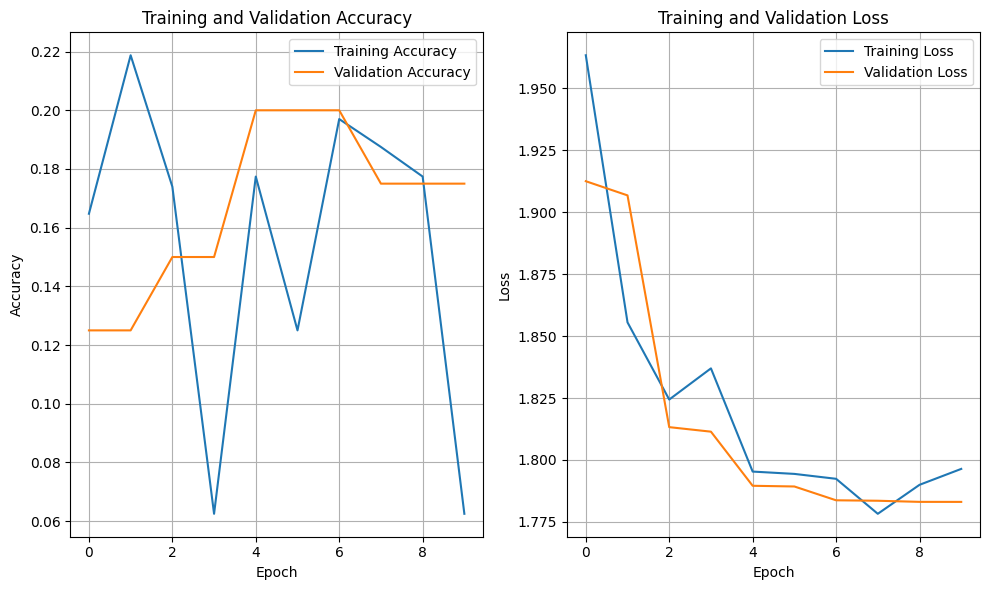

In [23]:
# Extract the metrics from the history object
metrics_df = pd.DataFrame(history.history)

# Plot the training history for 'categorical_accuracy'
fig, axes= plt.subplots(1, 2, figsize=(10, 6))

# Plot Accuracy
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy')
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss')
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [24]:
result = new_model.evaluate(test_generator, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - categorical_accuracy: 0.1541 - loss: 1.7854
Test-set classification accuracy: 15.07%


# Unfreeze Resnet50 layers to retrain

In [25]:
conv_model.trainable = True

In [26]:
for layer in conv_model.layers:
  if('conv5' not in layer.name): # only layers from conv5 (the last block) remain trainable
    layer.trainable = False
  if('bn' in layer.name): # do not train batch normalization layers
    layer.trainable = False

In [27]:
optimizer_fine_tuning = Adam(learning_rate=1e-5) # A low learning rate refines weights gradually instead of overwriting them.

In [28]:
new_model.compile(optimizer=optimizer_fine_tuning, loss=loss, metrics=lst_metrics)

In [29]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          12,294 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 14,965,766 (57.09 MB)

 Non-trainable params: 8,634,240 (32.94 MB)

In [34]:
fine_tuning_epochs = 40
total_epochs = initial_epochs + fine_tuning_epochs

In [35]:
history_fine_tuning = new_model.fit(train_generator,
                    epochs=total_epochs,
                    initial_epoch=len(history.epoch),  #already trained top for 10 epochs above before unfreezing, start counter at 11
                    steps_per_epoch=steps_train,
                    validation_data=val_generator,
                    callbacks = [early_stopping_cb]
                    )

Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 938ms/step - categorical_accuracy: 0.1708 - loss: 1.8084 - val_categorical_accuracy: 0.1750 - val_loss: 1.7991
Epoch 12/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - categorical_accuracy: 0.1250 - loss: 1.7837

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.1250 - loss: 1.7837 - val_categorical_accuracy: 0.1750 - val_loss: 1.7968
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - categorical_accuracy: 0.1755 - loss: 1.7934 - val_categorical_accuracy: 0.1500 - val_loss: 1.7857
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - categorical_accuracy: 0.1562 - loss: 1.8003 - val_categorical_accuracy: 0.1500 - val_loss: 1.7887
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - categorical_accuracy: 0.1960 - loss: 1.7873 - val_categorical_accuracy: 0.2000 - val_loss: 1.7723
Epoch 16/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.1250 - loss: 1.8493 - val_categorical_accuracy: 0.1750 - val_loss: 1.7698
Epoch 17/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 473ms/step - categorical_accuracy: 0.1803 - loss: 1.7886 - val_categorical_accuracy: 0.3500 - val_loss: 1.7602
Epoch 18/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.1562 - loss: 1.785

In [ ]:
# Extract the metrics from the history object
metrics_df = pd.DataFrame(history_fine_tuning.history)

# Plot the training history for 'categorical_accuracy'
fig, axes= plt.subplots(1, 2, figsize=(10, 6))

# Plot Accuracy
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['categorical_accuracy'], label='Training Accuracy')
sns.lineplot(ax= axes[0], x=metrics_df.index, y=metrics_df['val_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot Loss
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['loss'], label='Training Loss')
sns.lineplot(ax= axes[1], x= metrics_df.index, y= metrics_df['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()